In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation

%matplotlib inline

#Setting constants 
ep_0 = 8.8541878*(10**(-12))
mew_0 = 4*(np.pi)*(10**(-7))
c0 = 299792458

In [2]:
class Grid:
    
    def __init__(self, grid_res = 0.1, t_steps = 500, x_steps = 200, y_steps = 200):
        
        self.ds = grid_res      #Grid Resolution (size of space step)
        self.x_steps = x_steps  #No. of point on x axis
        self.y_steps = y_steps  #No. of point on y axis
        
        self.x_len  = (self.x_steps-1)*self.ds
        self.x_axis = np.linspace(0, self.x_len, self.x_steps) 
        
        self.y_len  = (self.y_steps-1)*self.ds
        self.y_axis = np.linspace(0, self.y_len, self.y_steps)
        
        self.dt = self.ds/(np.sqrt(2.0)*c0) #dt is chosen using courant stability condition
        
        self.t_steps = t_steps              #No. of steps in simulation
        self.time_period = (self.t_steps-1)*self.dt
        self.t_axis = np.linspace(0, self.time_period, self.t_steps)
        
        self.mew_r = np.ones((self.x_steps,self.y_steps)) #relative permeability at every point in the grid; set to 1 in constructor
        self.ep_r = np.ones((self.x_steps,self.y_steps))  #relative permittivity at every point in the grid; set to 1 in constructor
        self.σ = np.zeros((self.x_steps,self.y_steps)) #electriclal conductivity at every point in the grid; set to 0 in constructor
        self.n = np.sqrt(self.mew_r*self.ep_r)  # refractive index at every point in the grid
        
        self.Es = np.zeros((self.t_steps, self.x_steps, self.y_steps))
    
    def set_environment_parameters(self, mew_r = 1.0, ep_r =1.0, σ = 0.0, method = 'half Y'):
        
        """ Sets environment parameters for the grid
        -User can provide elec. conductivity, rel. permeability or rel. permittivity values to be set for entire or portion of the grid points 
        -User can choose from 'whole grid', 'half X', and 'half Y' using keyword "method"
        
        Kwargs:
            mew_r (float): relative permeability
            ep_r  (float): relative permittivity
            σ     (float): electrical conductivity
        
        Returns:
            None
        """
        if method == 'whole grid':
            self.mew_r[:,:] = mew_r  # relative permeability in whole grid
            self.ep_r[:,:] = ep_r   # relative permittivity in whole grid
            self.σ[:,:] = σ  # electrical conductivity in whole grid
            self.n = np.sqrt(self.mew_r*self.ep_r)
        
        elif method == 'half Y':
            self.mew_r[:,self.y_steps//2:-4] = mew_r  # relative permeability in part of the grid
            self.ep_r[:,self.y_steps//2:-4]  = ep_r   # relative permittivity in part of the grid
            self.σ[:,self.y_steps//2:-4] = σ  # electrical conductivity in part of the grid
            self.n = np.sqrt(self.mew_r*self.ep_r)
        
        elif method == 'half X':
            self.mew_r[4:self.x_steps//2,:] = mew_r  # relative permeability in part of the grid
            self.ep_r[4:self.x_steps//2,:]  = ep_r   # relative permittivity in part of the grid
            self.σ[4:self.x_steps//2,:] = σ  # electrical conductivity in part of the grid
            self.n = np.sqrt(self.mew_r*self.ep_r)
         
        return None
    
    def set_source(self, x_pos, y_pos, kind = 'Gaussian'):
        """Generates source of EM waves
        -User can choose type of source using keyword "kind" and set source

        Args:
            x_pos (int): x position index of source
            y_pos (int): y position index of source
        
        Kwargs:
            kind (string): Source type, can be 'Gaussian'

        Returns:
            None
        """
        
        if kind == 'Gaussian':
            #Gaussian source (impulse)
            #Source Parameters
            tau = 10*self.dt
            t0  = 10*tau
            #Generating Electric Field source over time
            self.Es[:, x_pos, y_pos] += np.exp(-((self.t_axis-t0)/tau)**2) 
        
        return None


In [3]:
def FDTD(Grid):
    """ Simulates EM Waves using "Finite Difference Time Domain" method
    
    Args:
        Grid (Grid Object): Grid over which the simulation is done
        
    Returns:
        HxOverTime: Numpy array of Hx values over grid over time 
        HyOverTime: Numpy array of Hy values over grid over time 
        EyOverTime: Numpy array of Ez values over grid over time 
        
        such that EzOverTime[t][x,y] gives value of z component of Electric field at time t and position (x,y) on the grid
        (x,y and t are indexes for points on x_axis, y_axis and t_axis respectively)
    
    Notes:    
        Simulation is done in 2D over XY plane. (d/dz is assumed to be 0, 
        i.e; materials extended infinitely along z axis and no change is observed)
            Expanding Mexwell's equations given this conditions retuens two independant modes of EM waves
            Ez mode of EM wave is simulated

        Dirichlet Boundary Conditions are applied 
            Everything outside the simulated grid is set to 0, and so the EM wave is reflected back into the grid

        Loss is introduced by adding electrical conductivity σ, and update coefficients for electric field E are modified accordingly
    """

    dt = Grid.dt
    ds = Grid.ds
    
    mew_r = Grid.mew_r
    ep_r  = Grid.ep_r
    σ     = Grid.σ
    
    #Update Coefficients for fdtd (chosen basedon Maxwell's equations with normalized Electric and Magnetic field values)
    mH = (-dt*c0/(mew_r*ds))

    mE1 = (2*ep_0*ep_r - σ*dt)/(2*ep_0*ep_r + σ*dt)
    mE2 = 2*ep_0*c0*dt/(ds*(2*ep_0*ep_r + dt*σ))
    
    HxOverTime = HyOverTime = EzOverTime = np.zeros((1, Grid.x_steps, Grid.y_steps)) 

    for t in range(1, Grid.t_steps, 1):

        Hx = HxOverTime[t-1]
        Hy = HyOverTime[t-1]
        Ez = EzOverTime[t-1]

        Hx[:,:-1] += mH[:,:-1]*(Ez[:,1:]-Ez[:,:-1])  #Change in Ez over y
        Hx[:,-1] += mH[:,-1]*(0-Ez[:,-1]) #Boundary Condition (y high)

        HxOverTime = np.append(HxOverTime, np.array([Hx]), axis=0)

        Hy[:-1,:] -= mH[:-1,:]*(Ez[1:,:]-Ez[:-1,:])  #Change on Ez over x
        Hy[-1,:] -= mH[-1,:]*(0-Ez[-1,:])  #Boundary Condition (x high)

        HyOverTime = np.append(HyOverTime, np.array([Hy]), axis=0)

        CHz = np.zeros(Ez.shape)  #z component of curl of H
        CHz[1:,:] += (Hy[1:,:]-Hy[:-1,:])  #Change in Hy over x
        CHz[0,:] += (Hy[0,:]-0)  #Boundary Condition (x low)
        CHz[:,1:] -= (Hx[:,1:]-Hx[:,:-1])  #Change in Hx over y
        CHz[:,0] -= (Hx[:,0]-0)  #Boundary Condition (y low)
        CHz[0,0] += Hy[0,0] - Hx[0,0]  #Boundary Condition (origin)
        Ez = mE1[:,:]*Ez + mE2[:,:]*CHz[:,:]

        Ez += Grid.Es[t]  #injecting source at a point in the grid

        EzOverTime = np.append(EzOverTime, np.array([Ez]), axis=0)
    
    return HxOverTime, HyOverTime, EzOverTime

In [4]:
def reflectance_t0_ep_r(R):
    if R == 1:
        ep_r = 10**20   #arbitrarily large number to stand in for infinity
    else:
        ep_r = ((1+np.sqrt(R))/(1-np.sqrt(R)))**2
    return ep_r

In [5]:
R = 0.04   #Random test value
T = 1.0 - R 
L = 0.0

EMGrid = Grid(t_steps = 300)
EMGrid.set_environment_parameters(mew_r = 1.0, ep_r = reflectance_t0_ep_r(R), σ = 0*10**(-3), method = 'half Y')
EMGrid.set_source(x_pos = EMGrid.x_steps//2, y_pos = EMGrid.y_steps//3, kind = 'Gaussian')

HxOverTime, HyOverTime, EzOverTime = FDTD(EMGrid)

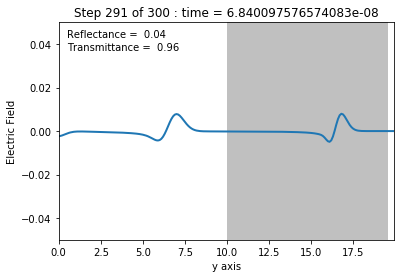

In [6]:
#Animation (Ez Over Y axis)

fig = plt.figure(figsize=(6,4))
ax = plt.axes(xlim=(0, EMGrid.x_len), ylim = (-0.05,0.05))

plt.text(0.5, 0.043, 'Reflectance =  %.2f' %R)
plt.text(0.5, 0.037, 'Transmittance =  %.2f' %T)

#The region with different refractive index is colored silver
for i in range(0, EMGrid.y_steps, 1):
    if EMGrid.n[100,i] == 1.0:
        plt.axvspan(i*EMGrid.ds, (i+1)*EMGrid.ds, facecolor='w')
    else:
        plt.axvspan(i*EMGrid.ds, (i+1)*EMGrid.ds, facecolor='silver')

ax.set_xlabel('y axis')
ax.set_ylabel('Electric Field')

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

#The E field over y axis is plotted every 10th time step
def animate(t):
    x = EMGrid.y_axis
    y = EzOverTime[10*t, EMGrid.x_steps//2]
    plt.title("Step " + str(10*t+1) + " of " + str(EMGrid.t_steps)+ " : time = " + str(10*t*EMGrid.dt))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=EMGrid.t_steps//10, interval=1, blit=True)

anim.save("EzOverY.gif", writer='imagemagick')

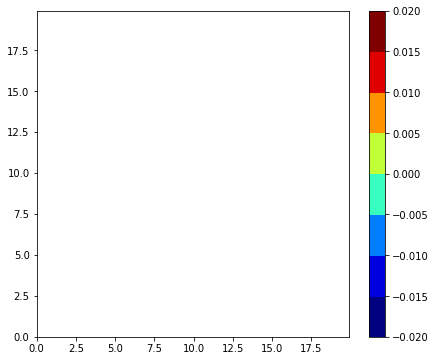

In [7]:
#Animation (Ez Over XY plane - Contour)

fig = plt.figure(figsize=(7,6))
ims = []

#The contour plot of E field over xy plane is plotted every 5th time step
for t in range(0, EMGrid.t_steps, 5):
    im = plt.contourf(EMGrid.x_axis, EMGrid.y_axis, EzOverTime[t].T, cmap= 'jet', vmax=0.015,vmin=-0.015)
    ims.append(im.collections)

cbar = plt.colorbar(im)

ani = ArtistAnimation(fig, ims, interval=150, repeat=True)

ani.save("EzOverXY.gif", writer='imagemagick') 

Based on Reference material on FDTD analysis from https://empossible.net/academics/emp5304/